In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv(r"C:\Users\shara\Downloads\CarPrice_Assignment.csv")

# Basic exploration
print("Shape:", df.shape)
print("Data types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Extract car brand
df['CarBrand'] = df['CarName'].apply(lambda x: x.split(' ')[0].lower())

# Fix misspelled brands
df['CarBrand'] = df['CarBrand'].replace({
    'vw': 'volkswagen', 'vokswagen': 'volkswagen',
    'porcshce': 'porsche', 'toyouta': 'toyota',
    'nissan': 'nissan', 'maxda': 'mazda'
})

# Drop car_ID and CarName
df.drop(['car_ID', 'CarName'], axis=1, inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Feature scaling for some models
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Shape: (205, 26)
Data types:
 car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

Missing values:
 car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase   

In [3]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Dictionary to store models and results
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

results = []

# Training & evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "R2 Score": r2,
        "MSE": mse,
        "MAE": mae
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="R2 Score", ascending=False))


               Model  R2 Score           MSE          MAE
2      Random Forest  0.958267  3.294575e+06  1293.233793
3  Gradient Boosting  0.924181  5.985429e+06  1710.336389
0  Linear Regression  0.910162  7.092188e+06  1760.870731
1      Decision Tree  0.906907  7.349134e+06  1782.589439
4                SVR -0.100615  8.688696e+07  5701.535525


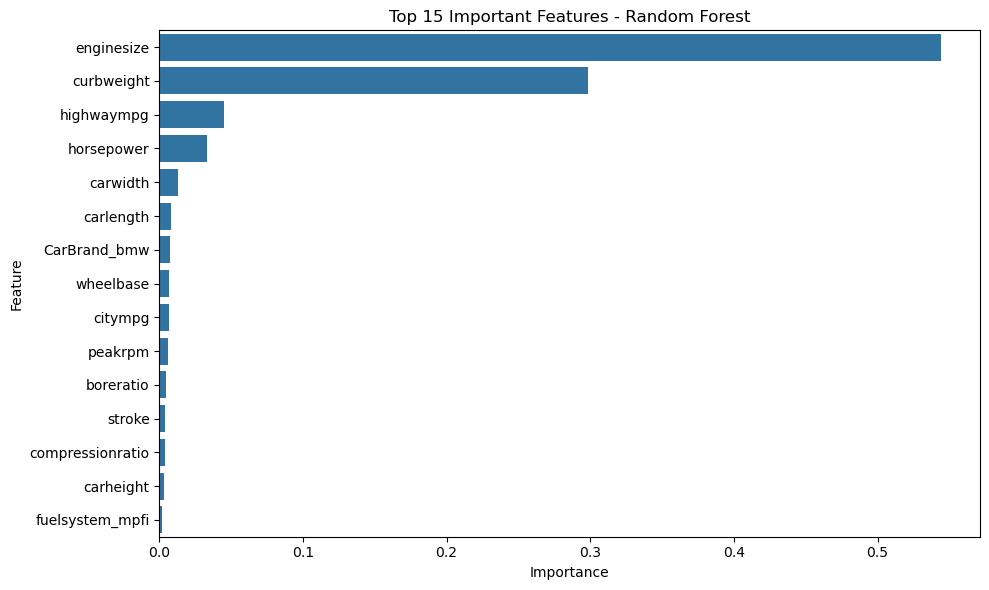

In [5]:
import matplotlib.pyplot as plt

# Use the best performing model – let's say it's Random Forest for now
best_model = models["Random Forest"]
feature_importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(15))
plt.title('Top 15 Important Features - Random Forest')
plt.tight_layout()
plt.show()


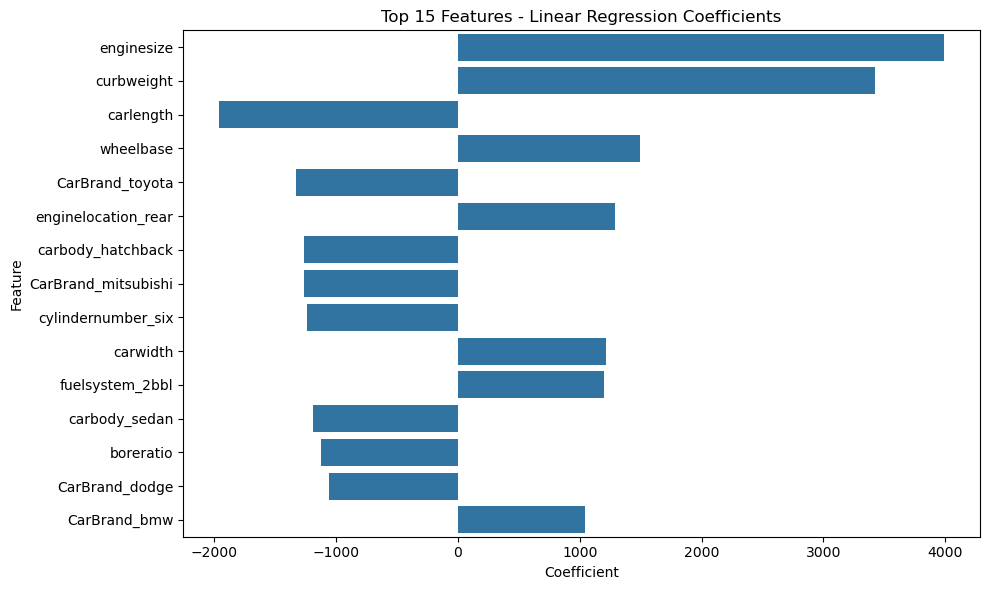

In [7]:
# Coefficients from Linear Regression
lin_model = models["Linear Regression"]
coefs = lin_model.coef_

lin_feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=lin_feat_df.head(15))
plt.title('Top 15 Features - Linear Regression Coefficients')
plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
rf_random.fit(X_train, y_train)

# Best params
print("Best parameters:", rf_random.best_params_)

# Evaluate
best_rf = rf_random.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_tuned)
mse = mean_squared_error(y_test, y_pred_tuned)
mae = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned Random Forest Performance:\nR2: {r2:.4f}, MSE: {mse:.2f}, MAE: {mae:.2f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\shara\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
31 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shara\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shara\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\shara\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\shara\anaconda3\Lib\site-packages

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Tuned Random Forest Performance:
R2: 0.9312, MSE: 5430698.25, MAE: 1404.29
